<a href="https://colab.research.google.com/github/tiachoi2001/ToBigs20/blob/main/Week9_RSBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
movies = pd.read_csv('/content/drive/MyDrive/ToBigs_session/Week9/ml-latest-small/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ToBigs_session/Week9/ml-latest-small/ml-latest-small/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/ToBigs_session/Week9/ml-latest-small/ml-latest-small/tags.csv')

- 데이터 summary

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

- 전처리

In [10]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


- 평점순 구하기

In [11]:
ratings_mean = ratings.copy()[['movieId', 'rating']]
ratings_mean = ratings_mean.groupby('movieId').mean()

ratings_mean.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [12]:
ratings_order = ratings_mean.sort_values("rating", ascending = False)

In [13]:
ratings_order

,rating
movieId,
88448,5.0
100556,5.0
143031,5.0
143511,5.0
143559,5.0
...,...
157172,0.5
85334,0.5
53453,0.5


- 평점 distribution 확인

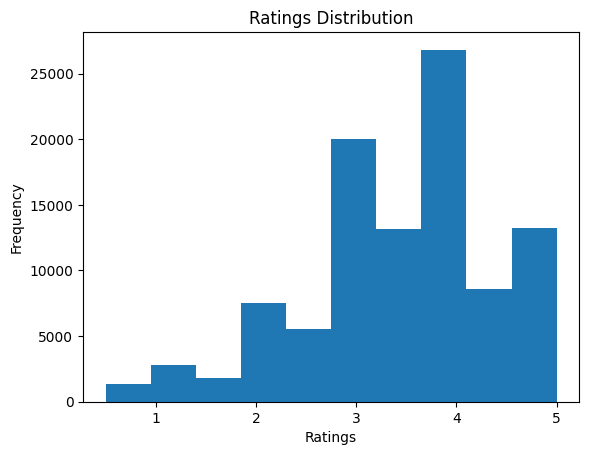

In [14]:
import matplotlib.pyplot as plt

ratings['rating'].plot(kind='hist', bins=10, title='Ratings Distribution')
plt.xlabel('Ratings')
plt.show()

- 장르 distribution

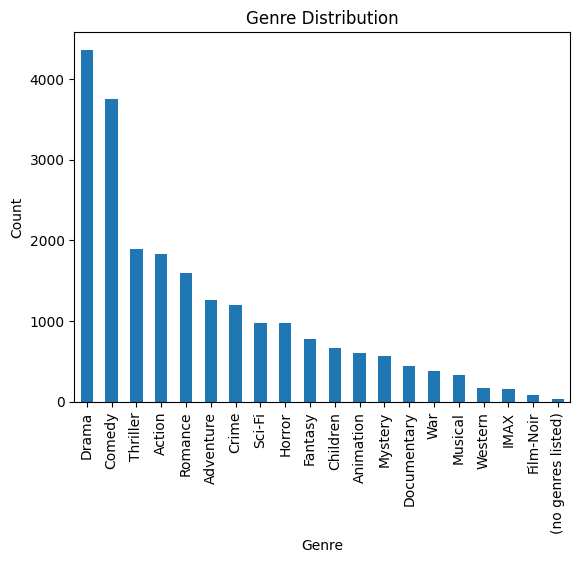

In [15]:
all_genres = [genre for genres in movies['genres'] for genre in genres]

genre_counts = pd.Series(all_genres).value_counts()

genre_counts.plot(kind='bar', title='Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

- user 분석

In [16]:
ratings_per_user = ratings['userId'].value_counts()
print('Number of Ratings per User:')
print(ratings_per_user.head())

tags_per_user = tags['userId'].value_counts()
print('Number of Tags per User:')
print(tags_per_user.head())

Number of Ratings per User:
414    2698
599    2478
474    2108
448    1864
274    1346
Name: userId, dtype: int64
Number of Tags per User:
474    1507
567     432
62      370
599     323
477     280
Name: userId, dtype: int64


- 태그 개수

In [17]:
tag_counts = tags['tag'].value_counts()
top_tags = tag_counts.head(10)
print('Top 10 Most Common Tags:')
print(top_tags)

Top 10 Most Common Tags:
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
surreal               23
Disney                23
religion              22
sci-fi                21
quirky                21
Name: tag, dtype: int64


Memory-based CF (KNNBaseline)

In [18]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156242 sha256=326b0244c69330a40ddc8b8c2a997d6305ff21f4469a414f703e3eb2c6199bb0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [19]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [20]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [21]:
from surprise import KNNBaseline

sim_options = {
    'name': 'cosine',
    'user_based': False
}
model = KNNBaseline(sim_options=sim_options)
model.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
from surprise import accuracy

predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.8979
RMSE: 0.8978762527408348


Memory-based CF (KNNBasic)

In [23]:
from surprise import KNNBasic

sim_options = {
    'name': 'cosine',
    'user_based': False
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [24]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.9800
RMSE: 0.9799629843055228


Model-based CF ()

In [25]:
from surprise import SVD
from surprise import accuracy

model = SVD()
model.fit(trainset)
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.8800
RMSE: 0.8799521887761322
